In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tabulate import tabulate
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler


In [2]:
# File Paths
absolute_path = "C:\\Users\\tykun\\\OneDrive\\Documents\\SchoolDocs\VSCodeProjects\\connectedData\\board_analysis\\"
altered_dataframes = "altered_dataframes\\"
gpt_dataframes = "gpt_dataframes\\"
graphs = "graphs\\"
scripts =  "scripts\\"
board_dataframes = "board_dataframes\\"
temporary = "temporary_data\\"
college_matching = "college_matching\\"

altered_dataframe_path = f"{absolute_path}{altered_dataframes}"
gpt_dataframe_path = f"{absolute_path}{gpt_dataframes}" 
graph_path = f"{absolute_path}{graphs}"
script_path = f"{absolute_path}{scripts}"
boards_path = f"{absolute_path}{board_dataframes}"
temporary_data_path = f"{absolute_path}{temporary}"
college_matching_path = f"{absolute_path}{college_matching}"


# Valid Years
years = ["1999", "2000", "2005", "2007", "2008", "2009", "2011", "2013", "2018"]

#Created Files
university_boards_statistics_path = f"{altered_dataframe_path}sample_board_statistics.csv"
university_admissions_path = f"{college_matching_path}university_admission_rate.csv"
university_demographics_path = f"{college_matching_path}university_student_demographics.csv"

In [3]:
university_board_statistics_df = pd.read_csv(university_boards_statistics_path)
university_admissions_df = pd.read_csv(university_admissions_path)
university_demographics_df = pd.read_csv(university_demographics_path)

In [4]:
# Merge admissions data into board stats
university_board_statistics_df = university_board_statistics_df.merge(
    university_admissions_df.rename(columns={"year": "Year"}), 
    on=["Year", "AffiliationId"], 
    how="left"
)

# Merge demographics data into board stats
university_board_statistics_df = university_board_statistics_df.merge(
    university_demographics_df.rename(columns={"year": "Year"}), 
    on=["Year", "AffiliationId"], 
    how="left"
)

# print(university_board_statistics_df.head())


In [5]:
def remove_non_samples(df):
    df = df[df['PrimarySample'] == True]
    return df

In [6]:
university_board_statistics_df['female_proportion'] = \
         university_board_statistics_df.apply(
             lambda row: row['female'] / row['total_members'] if row['total_members'] > 0 else 0,
             axis=1
         )

university_board_statistics_df['poc_proportion'] = \
         university_board_statistics_df.apply(
             lambda row: row['poc'] / row['total_ethnicity'] if row['total_ethnicity'] > 0 else 0,
             axis=1
         )

# Calculate the proportion of billionaires on the board
university_board_statistics_df['billionaire_proportion'] = (
    university_board_statistics_df['num_billionaires'] / 
    university_board_statistics_df['total_members'].replace(0, np.nan)
).fillna(0)

university_board_statistics_df = remove_non_samples(university_board_statistics_df)

university_board_statistics_df.to_csv(university_boards_statistics_path, index=False)


In [7]:
# ============================
# 1. Data Preparation
# ============================



# Independent variables

#do a tenure and a turnover one
independent_vars = [
    "admissions.admission_rate.overall", 
    "student.students_with_pell_grant", 
    "female_proportion",
    "billionaire_proportion",  # Normalized proportion of billionaires
    "total_members",
    "Eigenvector",
    "student.demographics.women",
    "poc_proportion",
    "board_turnover"
]

# Dependent variable: female president (True/False)
dependent_var = "female_president"

# Time variable
year_var = "Year"

# ============================
# 2. Data Cleaning and Encoding
# ============================

# -- 1. Drop rows with missing data
regression_data = university_board_statistics_df.dropna(
    subset=[dependent_var] + independent_vars + [year_var]
).copy()

# -- 1.a. Check unique years after dropping missing data
unique_years = regression_data['Year'].unique()
print(f"Unique years in the data after dropping missing values: {unique_years}")
print(f"Number of unique years: {len(unique_years)}")

# -- 2. Ensure the dependent variable is numeric (0/1)
regression_data[dependent_var] = regression_data[dependent_var].astype(int)

# -- 3. Create dummy variables for the Year (NOT for Institution)
regression_data = pd.get_dummies(
    regression_data,
    columns=[year_var],
    drop_first=True
)

# -- 3.a. Convert Year dummy variables from bool to int (if necessary)
year_dummies = [col for col in regression_data.columns if col.startswith(f"{year_var}_")]
# Some versions of pandas might create dummy variables as int, but ensure they are
regression_data[year_dummies] = regression_data[year_dummies].astype(int)

# -- 3.b. Verify number of year dummies
print(f"Number of year dummy variables: {len(year_dummies)}")
print(f"Year dummy variables: {year_dummies}")

# -- 4. Define predictors and outcome
all_predictors = independent_vars + year_dummies

X = regression_data[all_predictors]
y = regression_data[dependent_var]

# ============================
# 3. Standardization
# ============================

# -- 5. Identify continuous variables to scale (exclude year dummies)
continuous_vars = [
    "admissions.admission_rate.overall", 
    "student.students_with_pell_grant", 
    "female_proportion",
    "billionaire_proportion",  
    "total_members",
    "Eigenvector",
    "student.demographics.women",
    "poc_proportion",
    "board_turnover"
]

# Verify that these columns exist in X
missing_vars = [var for var in continuous_vars if var not in X.columns]
if missing_vars:
    print(f"Warning: The following continuous variables are missing from X and will not be scaled: {missing_vars}")

# -- 6. Standardize the continuous independent variables
scaler = StandardScaler()
# Fit and transform only existing continuous variables
vars_to_scale = [var for var in continuous_vars if var in X.columns]
X_scaled = X.copy()
X_scaled[vars_to_scale] = scaler.fit_transform(X_scaled[vars_to_scale])

# ============================
# 4. Ensuring All Predictors are Numeric
# ============================

# -- 7. Ensure all variables are numeric
print("\nData types of predictors after scaling:")
print(X_scaled.dtypes)

# Identify non-numeric columns
non_numeric_cols = X_scaled.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"\nError: The following predictor columns are not numeric and need to be converted: {non_numeric_cols}")
    # Optionally, handle them here (e.g., convert or drop)
    raise ValueError(f"Non-numeric columns detected: {non_numeric_cols}")

# ============================
# 5. Adding Intercept and Fitting the Model
# ============================

# -- 8. Add a constant term (intercept) to X
X_scaled = sm.add_constant(X_scaled)

# -- 9. Fit the logistic regression model
try:
    logit_model = sm.Logit(y, X_scaled)
    result = logit_model.fit()
except Exception as e:
    print(f"\nError fitting logistic regression model: {e}")
    raise

# -- 10. Print the summary
print("\nLogistic Regression Summary:")
print(result.summary())

# -- 11. Calculate odds ratios and p-values
odds_ratios = pd.DataFrame({
    "Variable": X_scaled.columns,
    "Coefficient": result.params,
    "Odds Ratio": np.exp(result.params),
    "P-Value": result.pvalues
})

print("\nOdds Ratios and P-Values:")
print(tabulate(odds_ratios, headers="keys", tablefmt="grid"))

# ============================
# 6. Calculating Variance Inflation Factors (VIF)
# ============================

# -- 12. Check if 'const' exists and drop it for VIF calculation
if 'const' in X_scaled.columns:
    X_check = X_scaled.drop('const', axis=1)
else:
    X_check = X_scaled.copy()

# -- 13. Calculate VIF for each predictor
vif_data = pd.DataFrame({
    "Variable": X_check.columns,
    "VIF": [variance_inflation_factor(X_check.values, i) for i in range(X_check.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(tabulate(vif_data, headers="keys", tablefmt="grid"))


Unique years in the data after dropping missing values: [2005 2007 2008 2009 2011 2013]
Number of unique years: 6
Number of year dummy variables: 5
Year dummy variables: ['Year_2007', 'Year_2008', 'Year_2009', 'Year_2011', 'Year_2013']

Data types of predictors after scaling:
admissions.admission_rate.overall    float64
student.students_with_pell_grant     float64
female_proportion                    float64
billionaire_proportion               float64
total_members                        float64
Eigenvector                          float64
student.demographics.women           float64
poc_proportion                       float64
board_turnover                       float64
Year_2007                              int32
Year_2008                              int32
Year_2009                              int32
Year_2011                              int32
Year_2013                              int32
dtype: object
Optimization terminated successfully.
         Current function value: 0.350865

In [8]:
# Format the 'Coefficient', 'Odds Ratio', and 'P-Value' columns
odds_ratios['Coefficient'] = odds_ratios['Coefficient'].map('{:.4f}'.format)
odds_ratios['Odds Ratio'] = odds_ratios['Odds Ratio'].map('{:.4f}'.format)
odds_ratios['P-Value'] = odds_ratios['P-Value'].map('{:.4f}'.format)

# Set 'Variable' as the index for better formatting in LaTeX
odds_ratios.set_index('Variable', inplace=True)

# Extract model statistics
mcfadden_r2 = 1 - (result.llf / result.llnull)
nobs = int(result.nobs)
log_likelihood = result.llf
ll_null = result.llnull
llr_pvalue = result.llr_pvalue

# Generate LaTeX table for odds ratios and p-values using pandas
latex_table = odds_ratios.to_latex(
    caption="Logistic Regression Results",
    label="tab:logistic_regression",
    float_format="%.4f",
    columns=["Coefficient", "Odds Ratio", "P-Value"],
    header=["Coefficient", "Odds Ratio", "P-Value"],
    index=True,
    escape=False,
    longtable=False,
    bold_rows=True,
    column_format="lccc",
    multicolumn=True,
    multicolumn_format='c'
)

# Create LaTeX code for model statistics
model_stats_latex = f"""
\\begin{{table}}[ht]
\\centering
\\begin{{tabular}}{{ll}}
\\toprule
\\textbf{{Statistic}} & \\textbf{{Value}} \\\\
\\midrule
McFadden's Pseudo R² & {mcfadden_r2:.4f} \\\\
Number of Observations & {nobs} \\\\
Log-Likelihood & {log_likelihood:.4f} \\\\
Null Log-Likelihood & {ll_null:.4f} \\\\
LLR p-value & {llr_pvalue:.4f} \\\\
\\bottomrule
\\end{{tabular}}
\\caption{{Model Statistics}}
\\label{{tab:model_statistics}}
\\end{{table}}
"""

# Combine both tables into a single LaTeX string
full_latex_output = f"""
\\begin{{table}}[ht]
\\centering
{latex_table}
\\caption{{Logistic Regression Results}}
\\label{{tab:logistic_regression}}
\\end{{table}}

{model_stats_latex}
"""

# Save the LaTeX output to a .tex file
with open("logistic_regression_results.tex", "w") as f:
    f.write(full_latex_output)

print("\nLaTeX table of logistic regression results saved to 'logistic_regression_results.tex'.")


LaTeX table of logistic regression results saved to 'logistic_regression_results.tex'.


In [9]:
# # Independent variables
# independent_vars = [
#     "admissions.admission_rate.overall", 
#     "student.demographics.avg_family_income", 
#     "student.demographics.poverty_rate"
# ]

# # Dependent variable: female president (True/False)
# dependent_var = "female_president"

# # Time variable
# year_var = "Year"

# # 1. Create interaction term first
# regression_data = university_board_statistics_df.copy()
# regression_data["female_proportion_total_members"] = regression_data["female_proportion"] * regression_data["total_members"]

# # 2. Drop rows with missing data
# predictor_vars = independent_vars + ["female_proportion_total_members"] + [year_var]
# regression_data = regression_data.dropna(
#     subset=[dependent_var] + predictor_vars
# ).copy()

# # 3. Ensure the dependent variable is numeric (0/1)
# regression_data[dependent_var] = regression_data[dependent_var].astype(int)

# # 4. Create dummy variables for Year
# regression_data = pd.get_dummies(
#     regression_data,
#     columns=[year_var],
#     drop_first=True
# )

# # 5. Define predictors and outcome
# all_predictors = independent_vars + ["female_proportion_total_members"] + [
#     col for col in regression_data.columns if col.startswith(f"{year_var}_")
# ]
# X = regression_data[all_predictors]
# y = regression_data[dependent_var]

# # 6. Add a constant term
# X = sm.add_constant(X)

# # 7. Fit two logistic regression models
# logit_model1 = sm.Logit(y, X).fit()

# # Simulating a slightly different model (example: dropping one predictor)
# X_model2 = X.drop(columns=["admissions.admission_rate.overall"])
# logit_model2 = sm.Logit(y, X_model2).fit()

# # 8. Stargazer table
# stargazer = Stargazer([logit_model1, logit_model2])
# stargazer.title("Logistic Regression Results")
# stargazer.custom_columns(["Model 1", "Model 2"], [1, 1])
# stargazer.show_model_numbers(False)

# # Render the LaTeX table
# latex_output = stargazer.render_latex()

# # 9. Save LaTeX output to a file
# with open("regression_table.tex", "w") as f:
#     f.write(latex_output)

# # Print LaTeX to console
# print(latex_output)


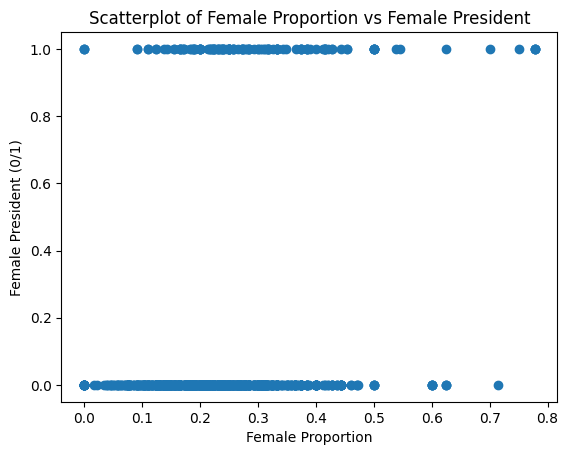

In [10]:
plt.scatter(regression_data['female_proportion'], regression_data['female_president'])
plt.xlabel('Female Proportion')
plt.ylabel('Female President (0/1)')
plt.title('Scatterplot of Female Proportion vs Female President')
plt.show()

Dependent Variable Distribution:
female_president
0    0.86531
1    0.13469
Name: proportion, dtype: float64


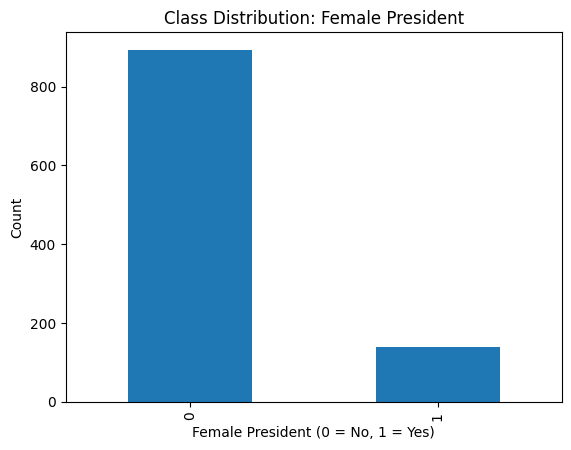

In [11]:
# Check Class Distribution
print("Dependent Variable Distribution:")
print(y.value_counts(normalize=True))

# Visualize class imbalance
y.value_counts().plot(kind='bar')
plt.title("Class Distribution: Female President")
plt.xlabel("Female President (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


In [12]:
# Ensure intercept is included
X_scaled = sm.add_constant(X_scaled)

# Predict probabilities
model_probs = result.predict(X_scaled)

# Group probabilities into deciles
data = pd.DataFrame({"Actual": y, "Predicted": model_probs})
data["Decile"] = pd.qcut(data["Predicted"], 10, labels=False)

# Calculate observed and expected counts
hosmer_lemeshow = data.groupby("Decile").apply(
    lambda g: pd.Series({
        "Observed_1": g["Actual"].sum(),
        "Expected_1": g["Predicted"].sum(),
        "Observed_0": (g["Actual"] == 0).sum(),
        "Expected_0": g["Predicted"].count() - g["Predicted"].sum(),
    })
)

# Compute the Chi-Squared statistic
hl_stat = (
    ((hosmer_lemeshow["Observed_1"] - hosmer_lemeshow["Expected_1"])**2 / hosmer_lemeshow["Expected_1"]) +
    ((hosmer_lemeshow["Observed_0"] - hosmer_lemeshow["Expected_0"])**2 / hosmer_lemeshow["Expected_0"])
).sum()

# Degrees of freedom
dof = 10 - 2
p_value = chi2.sf(hl_stat, dof)

print(f"Hosmer-Lemeshow Test Statistic: {hl_stat:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p_value:.4f}")

if p_value > 0.05:
    print("Model fits well (p > 0.05).")
else:
    print("Model does not fit well (p <= 0.05).")


Hosmer-Lemeshow Test Statistic: 14.45
Degrees of Freedom: 8
P-Value: 0.0708
Model fits well (p > 0.05).


C:\Users\tykun\AppData\Local\Temp\ipykernel_5832\3251944093.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hosmer_lemeshow = data.groupby("Decile").apply(


In [13]:
'''for cross validation'''

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {scores.mean():.4f}")


Cross-Validation Accuracy: 0.8672


c:\Users\tykun\OneDrive\Documents\SchoolDocs\VSCodeProjects\projectEnv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\tykun\OneDrive\Documents\SchoolDocs\VSCodeProjects\projectEnv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

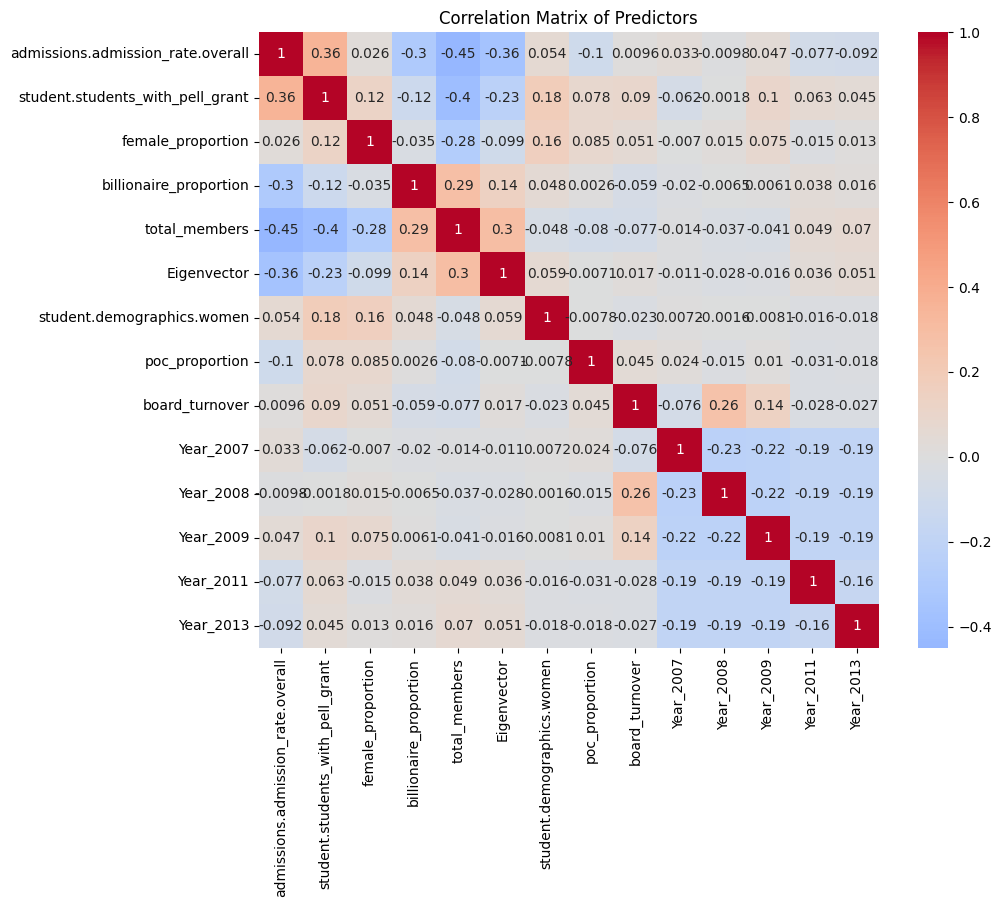

In [14]:
# Correlation Heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Predictors")
plt.show()
